In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/it-service-ticket-classification-dataset/all_tickets_processed_improved_v3.csv


кросс валидацию
грид серч / что-то для тьюнинга гиперпараметров
берт

# Loading data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adisongoh/it-service-ticket-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/it-service-ticket-classification-dataset


In [4]:
#reading df
df = pd.read_csv('/kaggle/input/it-service-ticket-classification-dataset/all_tickets_processed_improved_v3.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47837 entries, 0 to 47836
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Document     47837 non-null  object
 1   Topic_group  47837 non-null  object
dtypes: object(2)
memory usage: 747.6+ KB


In [6]:
#quick preview of the df
df.head()

,Document,Topic_group
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous


In [7]:
#viewing unique values (categories) in Topic_group
df['Topic_group'].nunique()
df['Topic_group'].unique()

array(['Hardware', 'Access', 'Miscellaneous', 'HR Support', 'Purchase',
       'Administrative rights', 'Storage', 'Internal Project'],
      dtype=object)

In [8]:
#checking na
df.isnull().sum()

Document       0
Topic_group    0
dtype: int64

In [9]:
#checking duplicates
df.duplicated().sum()

0

# Text Preprocessing

In [10]:
import re
import string
from bs4 import BeautifulSoup

In [11]:
def cleaned_text (text):
    text = text.lower() #converting to lower case
    text = re.sub(r'\d+', '', text) #removing numbers
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    #removing punctuation
    text = re.sub(r'\W', ' ', text) #removing special characters
    text = BeautifulSoup(text, "html.parser").get_text() #removing HTML tags
    return text

In [12]:
df['Cleaned_Document'] = df['Document'].apply(cleaned_text)

In [13]:
import nltk

#specifying the path to the already downloaded punkt dataset and other packages
nltk.data.path.append('/kaggle/input/nltk-datasets/nltk_data')

In [14]:
from nltk.tokenize import word_tokenize

In [15]:
#splitting text into words
df['Cleaned_Document'] = df['Cleaned_Document'].apply(word_tokenize)

In [16]:
df['Cleaned_Document']

0        [connection, with, icon, icon, dear, please, s...
1        [work, experience, user, work, experience, use...
2        [requesting, for, meeting, requesting, meeting...
3        [reset, passwords, for, external, accounts, re...
4        [mail, verification, warning, hi, has, got, at...
                               ...                        
47832    [git, space, for, a, project, issues, with, ad...
47833    [error, sent, july, error, hi, guys, can, you,...
47834    [connection, issues, sent, tuesday, july, conn...
47835    [error, cube, reports, sent, tuesday, july, er...
47836    [running, out, on, extensions, hello, please, ...
Name: Cleaned_Document, Length: 47837, dtype: object

In [17]:
#removing stop-words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
print(len(stop_words)) #checking that stop-words are downloaded

198


In [18]:
df['Cleaned_Document'] = df['Cleaned_Document'].apply(
    lambda toks: [w for w in toks if w not in stop_words]
)

In [19]:
df['Cleaned_Document']

0        [connection, icon, icon, dear, please, setup, ...
1        [work, experience, user, work, experience, use...
2        [requesting, meeting, requesting, meeting, hi,...
3        [reset, passwords, external, accounts, expire,...
4        [mail, verification, warning, hi, got, attache...
                               ...                        
47832    [git, space, project, issues, adding, users, s...
47833    [error, sent, july, error, hi, guys, help, err...
47834    [connection, issues, sent, tuesday, july, conn...
47835    [error, cube, reports, sent, tuesday, july, er...
47836    [running, extensions, hello, please, advised, ...
Name: Cleaned_Document, Length: 47837, dtype: object

In [20]:
#lemmatization
from nltk.stem import PorterStemmer, WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
df['Cleaned_Document'] = df['Cleaned_Document'].apply(lambda doc: [lemmatizer.lemmatize(word) for word in doc])

In [21]:
df['Cleaned_Document'].head(20)

0     [connection, icon, icon, dear, please, setup, ...
1     [work, experience, user, work, experience, use...
2     [requesting, meeting, requesting, meeting, hi,...
3     [reset, password, external, account, expire, d...
4     [mail, verification, warning, hi, got, attache...
5     [mail, please, dear, look, blacklisted, receiv...
6     [prod, server, tunneling, prod, tunneling, va,...
7     [access, request, dear, module, report, report...
8     [reset, password, client, password, client, de...
9     [direct, report, missing, time, please, action...
10    [laptop, connected, request, rebuild, connecte...
11    [device, recovery, report, printer, alert, dup...
12            [new, starter, hello, please, fill, date]
13    [visual, studio, license, visual, studio, lice...
14    [system, hello, movement, left, available, dev...
15    [access, secondary, secondary, hi, please, pro...
16    [list, sent, copy, copy, hi, receive, copy, be...
17    [new, purchase, po, purchase, po, dear, pu

In [22]:
df['Cleaned_Document'].tail(20)

47817    [submit, expense, even, though, added, electro...
47818    [job, referral, available, sent, thursday, jul...
47819    [oracle, update, another, bug, sent, thursday,...
47820    [social, error, sent, thursday, july, error, d...
47821    [backup, server, performance, issue, sent, thu...
47822    [approving, expense, project, code, related, w...
47823    [bug, sent, wednesday, july, bug, hello, disco...
47824    [oracle, fusion, working, message, unplanned, ...
47825    [issue, sent, friday, july, hi, issue, somethi...
47826    [oracle, error, sent, thursday, july, error, h...
47827    [bandwidth, problem, sent, thursday, july, ban...
47828    [password, expire, day, sent, july, password, ...
47829    [sensitive, information, access, sent, wednesd...
47830    [malfunction, sent, tuesday, july, malfunction...
47831    [outlook, account, laptop, laptop, sa, sa, si,...
47832    [git, space, project, issue, adding, user, sen...
47833    [error, sent, july, error, hi, guy, help, erro.

As I can see, besides stop words, the corpus contains many words like 'please', 'hi', 'hello', etc. These words can affect the efficiency of the algorithm, so I would remove them manually.

In [23]:
custom_stopwords = ['hi', 'hello', 'dear', 'please', 'help', 'guy', 'guys',
                   'thanks', 'thank', 'regards', 'best', 'hey', 'appreciate',
                    'sorry', 'welcome', 'cheers', 'hello', 'goodbye', 'bye',
                    'kindly', 'gladly']

df['Cleaned_Document'] = df['Cleaned_Document'].apply(
    lambda doc: [word for word in doc if word not in custom_stopwords]
)

In [24]:
df['Cleaned_Document']

0        [connection, icon, icon, setup, icon, per, ico...
1        [work, experience, user, work, experience, use...
2        [requesting, meeting, requesting, meeting, fol...
3        [reset, password, external, account, expire, d...
4        [mail, verification, warning, got, attached, a...
                               ...                        
47832    [git, space, project, issue, adding, user, sen...
47833    [error, sent, july, error, error, appearing, w...
47834    [connection, issue, sent, tuesday, july, conne...
47835    [error, cube, report, sent, tuesday, july, err...
47836    [running, extension, advised, running, extensi...
Name: Cleaned_Document, Length: 47837, dtype: object

In [25]:
#%pip install contractions
#import contractions

contraction_map = {
    "aren't": "are not",
    "can't": "cannot",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it's": "it is",
    "let's": "let us",
    "mightn't": "might not",
    "mustn't": "must not",
    "shan't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "shouldn't": "should not",
    "that's": "that is",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "we'd": "we would",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where's": "where is",
    "who's": "who is",
    "who'll": "who will",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have"
}

def expand_contractions_tokenized(doc):
    return [contraction_map.get(word, word) for word in doc]

df['Cleaned_Document'] = df['Cleaned_Document'].apply(expand_contractions_tokenized)

In [26]:
df['Cleaned_Document'] 

0        [connection, icon, icon, setup, icon, per, ico...
1        [work, experience, user, work, experience, use...
2        [requesting, meeting, requesting, meeting, fol...
3        [reset, password, external, account, expire, d...
4        [mail, verification, warning, got, attached, a...
                               ...                        
47832    [git, space, project, issue, adding, user, sen...
47833    [error, sent, july, error, error, appearing, w...
47834    [connection, issue, sent, tuesday, july, conne...
47835    [error, cube, report, sent, tuesday, july, err...
47836    [running, extension, advised, running, extensi...
Name: Cleaned_Document, Length: 47837, dtype: object

In [27]:
#saving dataset
df['Cleaned_Document_Str'] = df['Cleaned_Document'].apply(lambda tokens: ' '.join(tokens))
df.to_csv('cleaned_dataset.csv', index=False)

# EDA

In [28]:
#number of tokens per document.
df['doc_length'] = df['Cleaned_Document'].apply(len)
print(df['doc_length'].describe())

count    47837.000000
mean        33.148860
std         44.508495
min          0.000000
25%         12.000000
50%         20.000000
75%         35.000000
max        817.000000
Name: doc_length, dtype: float64


As we can see, there are some tickets with zero tokens, meaning they are essentially empty

In [29]:
df[df['doc_length'] == 0]

,Document,Topic_group,Cleaned_Document,Cleaned_Document_Str,doc_length
35590,for is down again for down again hi for down a...,Administrative rights,[],,0


In [30]:
df = df[df['doc_length'] != 0]

In [31]:
from nltk.probability import FreqDist
# Убираем NaN и взрываем списки токенов в один Series
doc = df['Cleaned_Document'].dropna().explode()

# Фильтруем только строки
doc = doc[doc.apply(lambda x: isinstance(x, str))]

# Считаем частоты
fdist = FreqDist(doc)

# Топ-10
top10 = fdist.most_common(10)
print(top10)

[('pm', 28902), ('regard', 27286), ('sent', 14717), ('issue', 14176), ('access', 13309), ('kind', 13252), ('tuesday', 10899), ('wednesday', 10429), ('error', 10152), ('thursday', 9937)]


In [32]:
#lexical diversity
total = len(doc)
unique = len(set(doc))
lex_div = unique / total
print(f"Lexical Diversity: {lex_div:.5f}")

Lexical Diversity: 0.00662


In [33]:
word_lengths = [len(w) for w in doc]
print(f"Avg. word length (mean): {np.mean(word_lengths):.2f}")
print(f"Avg. word length (median): {np.median(word_lengths):.2f}")

Avg. word length (mean): 6.14
Avg. word length (median): 6.00


In [34]:
ticket_length = [len(w) for w in df['Cleaned_Document']]
print(f"Avg. ticket length (mean): {np.mean(ticket_length):.2f}")
print(f"Avg. ticket length (median): {np.median(ticket_length):.2f}")

Avg. ticket length (mean): 33.15
Avg. ticket length (median): 20.00


<Axes: xlabel='Samples', ylabel='Counts'>

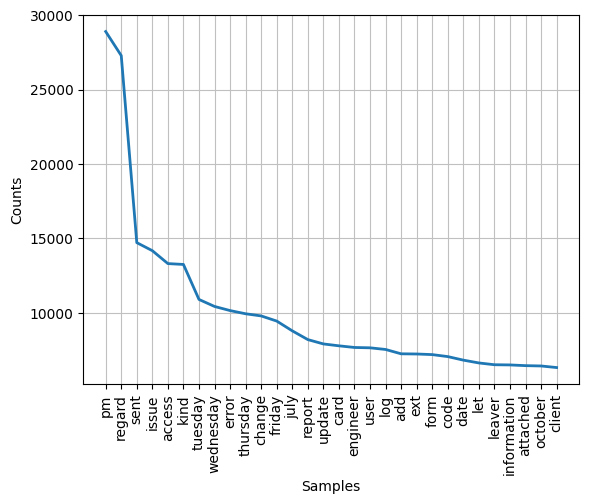

In [35]:
fdist.plot(30, cumulative=False)  

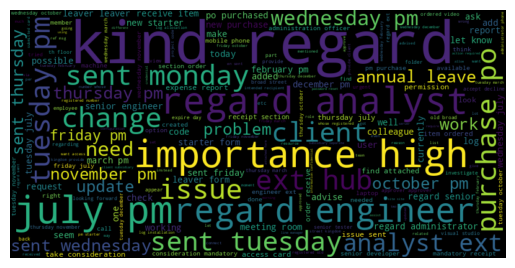

In [36]:
from wordcloud import WordCloud 
wc = WordCloud(width=800, height=400).generate(' '.join(doc))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Since it's classification task, let's check ticket distribution

In [37]:
df['Topic_group'].describe()

count        47836
unique           8
top       Hardware
freq         13617
Name: Topic_group, dtype: object

In [38]:
print(df['Topic_group'].value_counts())

Topic_group
Hardware                 13617
HR Support               10915
Access                    7125
Miscellaneous             7060
Storage                   2777
Purchase                  2464
Internal Project          2119
Administrative rights     1759
Name: count, dtype: int64


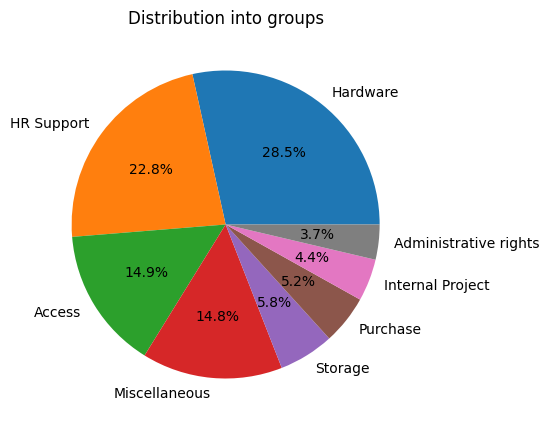

In [39]:
group_counts = df['Topic_group'].value_counts()

plt.figure(figsize=(7, 5))
plt.pie(group_counts, labels=group_counts.index, autopct="%1.1f%%" )
plt.title('Distribution into groups')
plt.show()

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47836 entries, 0 to 47836
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Document              47836 non-null  object
 1   Topic_group           47836 non-null  object
 2   Cleaned_Document      47836 non-null  object
 3   Cleaned_Document_Str  47836 non-null  object
 4   doc_length            47836 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.2+ MB


# Classification

**note: classes are imbalanced, check the perfomance later**

In [41]:
df.head()

,Document,Topic_group,Cleaned_Document,Cleaned_Document_Str,doc_length
0,connection with icon icon dear please setup ic...,Hardware,"[connection, icon, icon, setup, icon, per, ico...",connection icon icon setup icon per icon engin...,12
1,work experience user work experience user hi w...,Access,"[work, experience, user, work, experience, use...",work experience user work experience user work...,14
2,requesting for meeting requesting meeting hi p...,Hardware,"[requesting, meeting, requesting, meeting, fol...",requesting meeting requesting meeting follow e...,10
3,reset passwords for external accounts re expir...,Access,"[reset, password, external, account, expire, d...",reset password external account expire day ask...,112
4,mail verification warning hi has got attached ...,Miscellaneous,"[mail, verification, warning, got, attached, a...",mail verification warning got attached address...,11


In [42]:
df['Topic_group'].unique()

array(['Hardware', 'Access', 'Miscellaneous', 'HR Support', 'Purchase',
       'Administrative rights', 'Storage', 'Internal Project'],
      dtype=object)

In [43]:
#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, ngram_range=(1,2))
X = vectorizer.fit_transform(df['Cleaned_Document_Str'])

In [44]:
#encoding target variable
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(df['Topic_group'])

## Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89      1468
           1       0.91      0.64      0.75       331
           2       0.85      0.85      0.85      2110
           3       0.79      0.90      0.84      2761
           4       0.92      0.78      0.84       448
           5       0.83      0.84      0.83      1397
           6       0.98      0.87      0.92       499
           7       0.94      0.82      0.88       554

    accuracy                           0.85      9568
   macro avg       0.89      0.82      0.85      9568
weighted avg       0.86      0.85      0.85      9568



## Decision Trees / Random Forest / XGBoost:

In [47]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
rf_preds = rf_clf.predict(X_test)
print(classification_report(y_test, rf_preds))

              precision    recall  f1-score   support

           0       0.90      0.85      0.88      1468
           1       0.91      0.62      0.74       331
           2       0.84      0.86      0.85      2110
           3       0.77      0.89      0.83      2761
           4       0.93      0.78      0.85       448
           5       0.84      0.78      0.81      1397
           6       0.98      0.86      0.92       499
           7       0.93      0.77      0.84       554

    accuracy                           0.84      9568
   macro avg       0.89      0.80      0.84      9568
weighted avg       0.85      0.84      0.84      9568



## RNN

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47836 entries, 0 to 47836
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Document              47836 non-null  object
 1   Topic_group           47836 non-null  object
 2   Cleaned_Document      47836 non-null  object
 3   Cleaned_Document_Str  47836 non-null  object
 4   doc_length            47836 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.2+ MB


In [49]:
df.head()

,Document,Topic_group,Cleaned_Document,Cleaned_Document_Str,doc_length
0,connection with icon icon dear please setup ic...,Hardware,"[connection, icon, icon, setup, icon, per, ico...",connection icon icon setup icon per icon engin...,12
1,work experience user work experience user hi w...,Access,"[work, experience, user, work, experience, use...",work experience user work experience user work...,14
2,requesting for meeting requesting meeting hi p...,Hardware,"[requesting, meeting, requesting, meeting, fol...",requesting meeting requesting meeting follow e...,10
3,reset passwords for external accounts re expir...,Access,"[reset, password, external, account, expire, d...",reset password external account expire day ask...,112
4,mail verification warning hi has got attached ...,Miscellaneous,"[mail, verification, warning, got, attached, a...",mail verification warning got attached address...,11


TF-IDF converts text into a Bag-of-Words, ignoring the word order, which makes the data non-sequential. Since RNNs (recurrent neural networks) work with sequences, this format is not suitable for them. Therefore, data for RNNs must be prepared differently than for classical machine learning models.

In [50]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2025-06-09 14:25:43.509438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749479143.804330      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749479143.888449      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [51]:
#Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Cleaned_Document_Str'])

In [52]:
#Converting text into index sequences
sequences = tokenizer.texts_to_sequences(df['Cleaned_Document_Str'])
vocab_size = len(tokenizer.word_index) + 1

In [53]:
max_length = int(np.percentile([len(seq) for seq in sequences], 95))

In [54]:
X_seq = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

In [55]:
train_indices, test_indices = train_test_split(
    np.arange(len(df)), 
    test_size=0.2, 
    random_state=42,
    stratify=y  
)

In [56]:
X_train_seq = X_seq[train_indices]
X_test_seq = X_seq[test_indices]

In [57]:
X_train_rnn, X_test_rnn = X_train_seq, X_test_seq

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [59]:
model = Sequential([
    Embedding(vocab_size, 128, input_length=max_length),
    LSTM(64, return_sequences=False),
    Dense(len(le.classes_), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-06-09 14:26:01.039797: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [60]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [61]:
model.fit(X_train_rnn, y_train, 
          validation_data=(X_test_rnn, y_test),
          epochs=10, 
          batch_size=128)

Epoch 1/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 43s 129ms/step - accuracy: 0.2748 - loss: 1.8686 - val_accuracy: 0.2886 - val_loss: 1.8402
Epoch 2/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 39s 129ms/step - accuracy: 0.2832 - loss: 1.8364 - val_accuracy: 0.2886 - val_loss: 1.8416
Epoch 3/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 38s 128ms/step - accuracy: 0.2885 - loss: 1.8291 - val_accuracy: 0.2875 - val_loss: 1.8461
Epoch 4/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 38s 128ms/step - accuracy: 0.2989 - loss: 1.8095 - val_accuracy: 0.2853 - val_loss: 1.8548
Epoch 5/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 38s 128ms/step - accuracy: 0.3044 - loss: 1.7893 - val_accuracy: 0.2848 - val_loss: 1.8803
Epoch 6/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 38s 127ms/step - accuracy: 0.3070 - loss: 1.7739 - val_accuracy: 0.2843 - val_loss: 1.8883
Epoch 7/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 38s 129ms/step - accuracy: 0.3050 - loss: 1.7642 - val_accuracy: 0.2842 - val_loss: 1.9106
Epoch 8/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 38s 128ms/step - accuracy: 0.3176 - loss: 1

In [62]:
from tensorflow.keras.callbacks import EarlyStopping

In [63]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [64]:
history = model.fit(
    X_train_rnn, 
    y_train,
    epochs=15,
    batch_size=128,
    validation_split=0.1,  
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 33s 122ms/step - accuracy: 0.3219 - loss: 1.7421 - val_accuracy: 0.3123 - val_loss: 1.7735
Epoch 2/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 33s 121ms/step - accuracy: 0.3238 - loss: 1.7382 - val_accuracy: 0.3141 - val_loss: 1.7743
Epoch 3/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 33s 124ms/step - accuracy: 0.3282 - loss: 1.7352 - val_accuracy: 0.3094 - val_loss: 1.7825
Epoch 4/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 34s 125ms/step - accuracy: 0.3271 - loss: 1.7269 - val_accuracy: 0.3125 - val_loss: 1.7794


In [65]:
y_pred = model.predict(X_test_rnn)
y_pred_classes = np.argmax(y_pred, axis=1)

299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


In [66]:
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred_classes)

In [67]:
print("\nДетальный отчет по классификации:")
print(classification_report(y_test_labels, y_pred_labels))


Детальный отчет по классификации:
                       precision    recall  f1-score   support

               Access       0.16      0.02      0.03      1468
Administrative rights       0.08      0.00      0.01       331
           HR Support       0.20      0.01      0.02      2110
             Hardware       0.29      0.96      0.45      2761
     Internal Project       0.00      0.00      0.00       448
        Miscellaneous       0.21      0.01      0.02      1397
             Purchase       0.00      0.00      0.00       499
              Storage       0.08      0.01      0.01       554

             accuracy                           0.28      9568
            macro avg       0.13      0.13      0.07      9568
         weighted avg       0.19      0.28      0.14      9568



In [68]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

In [69]:
def build_model(hp):
    model = Sequential()
    
    # Embedding
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=hp.Choice('embedding_dim', [100, 150, 200]),
        input_length=max_length
    ))

    # LSTM
    model.add(LSTM(
        units=hp.Choice('lstm_units', [64, 128, 256]),
        dropout=hp.Float('lstm_dropout', 0.2, 0.5, step=0.1),
        recurrent_dropout=hp.Float('recurrent_dropout', 0.2, 0.5, step=0.1)
    ))

    # Dense + Dropout
    model.add(Dense(
        units=hp.Choice('dense_units', [32, 64, 128]),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dense_dropout', 0.2, 0.5, step=0.1)))

    # Output
    model.add(Dense(len(le.classes_), activation='softmax'))

    # Compile
    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [70]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,               # Кол-во комбинаций, которые протестирует
    executions_per_trial=1,      # Сколько раз обучать каждую модель
    directory='tuner_dir',
    project_name='rnn_text_class'
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [71]:
# Запускаем подбор
tuner.search(
    X_train_rnn, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=2)]
)

Trial 10 Complete [00h 11m 28s]
val_accuracy: 0.28102952241897583

Best val_accuracy So Far: 0.28102952241897583
Total elapsed time: 01h 29m 07s


In [72]:
# Получаем лучшую модель
best_model = tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [73]:
# Обучим финально на всём трейне
history = best_model.fit(
    X_train_rnn, y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=3)],
    verbose=1
)

Epoch 1/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 52s 100ms/step - accuracy: 0.2800 - loss: 1.8520 - val_accuracy: 0.2810 - val_loss: 1.8499
Epoch 2/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 82s 100ms/step - accuracy: 0.2796 - loss: 1.8439 - val_accuracy: 0.2810 - val_loss: 1.8485
Epoch 3/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 48s 101ms/step - accuracy: 0.2818 - loss: 1.8422 - val_accuracy: 0.2810 - val_loss: 1.8468
Epoch 4/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 47s 98ms/step - accuracy: 0.2815 - loss: 1.8404 - val_accuracy: 0.2810 - val_loss: 1.8464
Epoch 5/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 48s 100ms/step - accuracy: 0.2816 - loss: 1.8391 - val_accuracy: 0.2810 - val_loss: 1.8460
Epoch 6/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 82s 100ms/step - accuracy: 0.2815 - loss: 1.8470 - val_accuracy: 0.2810 - val_loss: 1.8464
Epoch 7/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 48s 100ms/step - accuracy: 0.2821 - loss: 1.8385 - val_accuracy: 0.2810 - val_loss: 1.8459
Epoch 8/15
479/479 ━━━━━━━━━━━━━━━━━━━━ 48s 100ms/step - accuracy: 0.2807 - loss: 1.

In [74]:
y_pred = best_model.predict(X_test_rnn)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(
    le.inverse_transform(y_test),
    le.inverse_transform(y_pred_classes)
))

299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
                       precision    recall  f1-score   support

               Access       0.00      0.00      0.00      1468
Administrative rights       0.00      0.00      0.00       331
           HR Support       0.00      0.00      0.00      2110
             Hardware       0.29      1.00      0.45      2761
     Internal Project       0.00      0.00      0.00       448
        Miscellaneous       0.00      0.00      0.00      1397
             Purchase       0.00      0.00      0.00       499
              Storage       0.00      0.00      0.00       554

             accuracy                           0.29      9568
            macro avg       0.04      0.12      0.06      9568
         weighted avg       0.08      0.29      0.13      9568



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## BERT

Since BERT-like models (including NeuroBERT-Tiny) expect **raw text strings** as input, at this stage the variable `x` should store the original document (`df['document']`), and not the previously cleaned one (`df['cleaned document']`).

In [75]:
#pip install transformers torch

In [76]:
##from transformers import AutoModelForMaskedLM, AutoTokenizer
#model = AutoModelForMaskedLM.from_pretrained("boltuix/NeuroBERT-Tiny")
#tokenizer = AutoTokenizer.from_pretrained("boltuix/NeuroBERT-Tiny")

In [77]:
#from transformers import AutoModelForMaskedLM, AutoTokenizer

#model = AutoModelForMaskedLM.from_pretrained("nreimers/NeuroBERT-tiny")
#tokenizer = AutoTokenizer.from_pretrained("nreimers/NeuroBERT-tiny")